# Bayesian approach to CMD classification

In [1]:
# imports
# imports 

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit
import matplotlib.colors as colors

import random
import healpy as hp

from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


# set the path to save plots
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/new_cmd'

# Computing Bayesian probabilities

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def compute_hvs_probability(x, y, df, x_col='bp_rp_corr', y_col='implied_M_g_corr', category_col='is_hvs'):
    """
    Computes the probability that a star with coordinates (x, y) is an HVS.

    Parameters:
    - x (float): The bp - rp color index of the star.
    - y (float): The absolute magnitude of the star.
    - df (pandas.DataFrame): DataFrame containing 'bp_rp', 'implied_G_mag', and 'is_hvs'.

    Returns:
    - dict: A dictionary with the probabilities for HVS=True and HVS=False.
    """
    # Extract features and labels
    X = df[[x_col, y_col]].values
    y_labels = df[category_col].values

    # Separate data by class
    X_hvs_true = X[y_labels == True]
    X_hvs_false = X[y_labels == False]

    # Calculate prior probabilities
    num_total = len(y_labels)
    num_hvs_true = np.sum(y_labels == True)
    num_hvs_false = np.sum(y_labels == False)

    P_hvs_true = num_hvs_true / num_total
    P_hvs_false = num_hvs_false / num_total

    # Compute mean and covariance for each class
    mean_hvs_true = np.mean(X_hvs_true, axis=0)
    cov_hvs_true = np.cov(X_hvs_true, rowvar=False)

    mean_hvs_false = np.mean(X_hvs_false, axis=0)
    cov_hvs_false = np.cov(X_hvs_false, rowvar=False)

    # Handle singular covariance matrices
    # Add a small diagonal matrix to make the covariance matrix positive definite
    epsilon = 1e-6
    cov_hvs_true += np.eye(2) * epsilon
    cov_hvs_false += np.eye(2) * epsilon

    # Create multivariate normal distributions
    mvn_hvs_true = multivariate_normal(mean=mean_hvs_true, cov=cov_hvs_true)
    mvn_hvs_false = multivariate_normal(mean=mean_hvs_false, cov=cov_hvs_false)

    # Compute likelihoods
    likelihood_hvs_true = mvn_hvs_true.pdf([x, y])
    likelihood_hvs_false = mvn_hvs_false.pdf([x, y])

    # Compute posteriors (unnormalized)
    unnormalized_posterior_hvs_true = likelihood_hvs_true * P_hvs_true
    unnormalized_posterior_hvs_false = likelihood_hvs_false * P_hvs_false

    # Normalize to get probabilities
    total = unnormalized_posterior_hvs_true + unnormalized_posterior_hvs_false
    if total == 0:
        # Avoid division by zero; return equal probabilities
        prob_hvs_true = prob_hvs_false = 0.5
    else:
        prob_hvs_true = unnormalized_posterior_hvs_true / total
        prob_hvs_false = unnormalized_posterior_hvs_false / total

    return {
        'P(HVS=True)': prob_hvs_true,
        'P(HVS=False)': prob_hvs_false
    }


## Testing

In [4]:

# load testing catalog
# load catalogs
# save the catalogs
#data_gaia_big= pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/CMD_selection_testing_catalog/large_catalog_evolved.feather')
data_gaia_big = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/training_catalog_CMD_classification/NSC_training_catalog_smaller.fits')
data_gaia_big = data_gaia_big.to_pandas()

In [5]:
total_hvs_sample = len(data_gaia_big.loc[data_gaia_big['is_hvs'] == 1])

In [6]:
# Coordinates of the star in question
x_i = 1.5  # example bp - rp color index
y_i = 4.7  # example absolute magnitude

# Compute the probabilities
probabilities = compute_hvs_probability(x_i, y_i, data_gaia_big)

print(f"Probability that the star is HVS: {probabilities['P(HVS=True)']:.4f}")
print(f"Probability that the star is not HVS: {probabilities['P(HVS=False)']:.4f}")

Probability that the star is HVS: 0.0769
Probability that the star is not HVS: 0.9231


## Plot probability distributions asuming a Gaussian for both distributions

In [ ]:
# plot 2D probability distribution
x_i = np.linspace(-1, 2.5, 100)
y_i = np.linspace(15, -7, 100)
X, Y = np.meshgrid(x_i, y_i)
hvs_prob = np.zeros(X.shape)
background_prob = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        probabilities = compute_hvs_probability(X[i, j], Y[i, j], data_gaia_big)
        hvs_prob[i, j] = probabilities['P(HVS=True)']
        background_prob[i, j] = probabilities['P(HVS=False)']


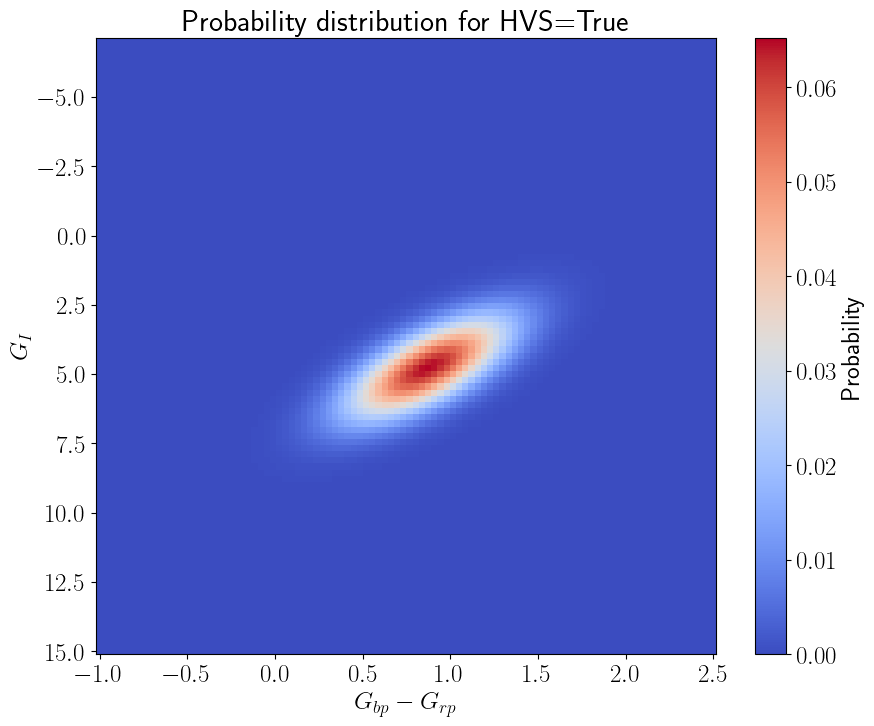

In [ ]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm', shading='auto')
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='Probability')
plt.savefig(os.path.join(plots_path, 'hvs_probability_distribution_KDE.png'))
plt.show()

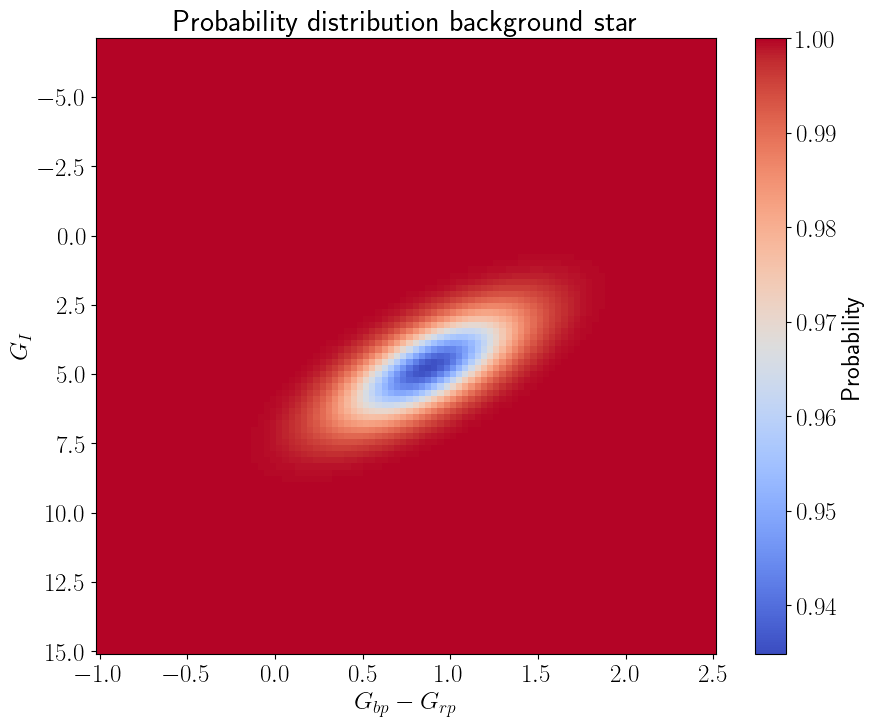

In [ ]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, background_prob, cmap='coolwarm', shading='auto')
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.invert_yaxis()
ax.set_title('Probability distribution background star')
fig.colorbar(c, label='Probability')
plt.savefig(os.path.join(plots_path, 'background_probability_distribution_KDE_NSC.png'))
plt.show()

# Two class bayesian disriminant classifier

In [8]:
import numpy as np
from sklearn.neighbors import KernelDensity

def bayesian_classifier_kde(X, Y, C, threshold=0.5, bandwidth=1.0):
    """
    Creates a Bayesian classifier based on KDE (non-parametric approach).
    
    Parameters:
    - X (array-like): Input data for feature X.
    - Y (array-like): Input data for feature Y.
    - C (array-like): Boolean feature indicating if a point is in the True class.
    - threshold (float): Probability threshold for classification (default is 0.5).
    - bandwidth (float): Bandwidth for KDE (smoothing parameter).
    
    Returns:
    - classify (function): A function that takes x, y values and returns a tuple containing:
      (classification (bool), P(class|x,y), P(not class|x,y), total probability).
    """
    
    # Convert input to numpy arrays for convenience
    X = np.array(X)
    Y = np.array(Y)
    C = np.array(C)
    
    # Split data by class
    X_class = X[C]
    Y_class = Y[C]
    X_not_class = X[~C]
    Y_not_class = Y[~C]
    
    # Calculate prior probabilities
    p_class = np.mean(C)
    p_not_class = 1 - p_class
    
    # Fit KDEs for each feature in each class
    kde_x_class = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_class.reshape(-1, 1))
    kde_y_class = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Y_class.reshape(-1, 1))
    kde_x_not_class = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_not_class.reshape(-1, 1))
    kde_y_not_class = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Y_not_class.reshape(-1, 1))
    

    def classify(x, y):
      # Ensure x and y are arrays for vectorized operations
      x = np.array(x).reshape(-1, 1)
      y = np.array(y).reshape(-1, 1)
      
      # Calculate log-likelihoods for all points at once
      log_p_x_given_class = kde_x_class.score_samples(x)
      log_p_y_given_class = kde_y_class.score_samples(y)
      log_p_x_given_not_class = kde_x_not_class.score_samples(x)
      log_p_y_given_not_class = kde_y_not_class.score_samples(y)
      
      # Convert log-likelihoods to likelihoods
      p_x_given_class = np.exp(log_p_x_given_class)
      p_y_given_class = np.exp(log_p_y_given_class)
      p_x_given_not_class = np.exp(log_p_x_given_not_class)
      p_y_given_not_class = np.exp(log_p_y_given_not_class)
      
      # Joint probabilities
      p_data_given_class = p_x_given_class * p_y_given_class
      p_data_given_not_class = p_x_given_not_class * p_y_given_not_class
      
      # Total probability of data
      p_data = p_data_given_class * p_class + p_data_given_not_class * p_not_class
      
      # Posterior probabilities P(class|data) and P(not class|data)
      p_class_given_data = (p_data_given_class * p_class) / p_data
      p_not_class_given_data = (p_data_given_not_class * p_not_class) / p_data
      
      # Classification based on threshold
      classification = p_class_given_data >= threshold
      
      return classification, p_class_given_data, p_not_class_given_data, p_data

    
    return classify


## Limit the training set to avoid outliers

In [41]:
# select CMD range to train in
data_gaia_big = data_gaia_big.loc[(data_gaia_big['implied_M_g_corr'] < 15) & (data_gaia_big['implied_M_g_corr'] > -7) & (data_gaia_big['bp_rp_corr'] > -1) & (data_gaia_big['bp_rp_corr'] < 2.5)]

In [9]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])
hvs_cmd_classifier = bayesian_classifier_kde(X, Y, C, threshold=0.1, bandwidth=0.1)

In [ ]:
hvs_cmd_classifier(1.5, 4.7)

# plot 2D probability distribution
x_i = np.linspace(-1, 2.5, 100)
y_i = np.linspace(15, -7, 100)
X, Y = np.meshgrid(x_i, y_i)
hvs_prob = np.zeros(X.shape)
background_prob = np.zeros(X.shape)
total_probability = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        classification, prob_hvs, prob_background, total_prob = hvs_cmd_classifier(X[i, j], Y[i, j])
        hvs_prob[i, j] = prob_hvs
        background_prob[i, j] = prob_background
        total_probability[i, j] = total_prob

In [143]:
# Generate the grid
x_i = np.linspace(-1, 2.5, 100)
y_i = np.linspace(15, -7, 100)
X, Y = np.meshgrid(x_i, y_i)

# Flatten X and Y to a 1D array of points
X_flat = X.ravel()
Y_flat = Y.ravel()

# Calculate probabilities for all points at once
classification, hvs_prob_flat, background_prob_flat, total_prob_flat = hvs_cmd_classifier(X_flat, Y_flat)

# Reshape the results back to the grid shape
hvs_prob = hvs_prob_flat.reshape(X.shape)
background_prob = background_prob_flat.reshape(X.shape)
total_probability = total_prob_flat.reshape(X.shape)


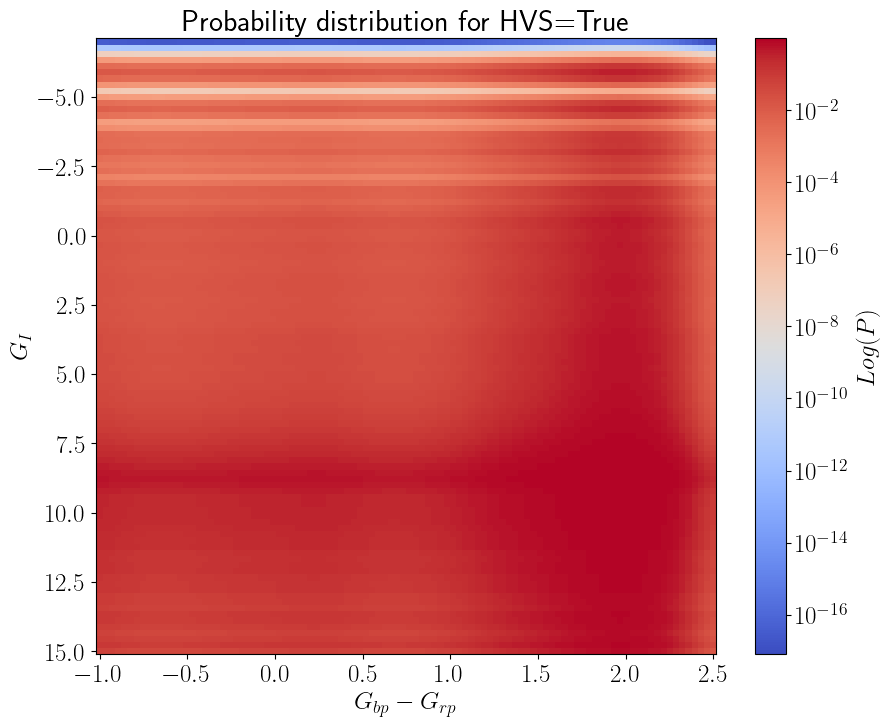

In [144]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm', shading='auto', norm=colors.LogNorm(vmin=hvs_prob.min(), vmax=hvs_prob.max()) )
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$Log(P)$')
plt.show()

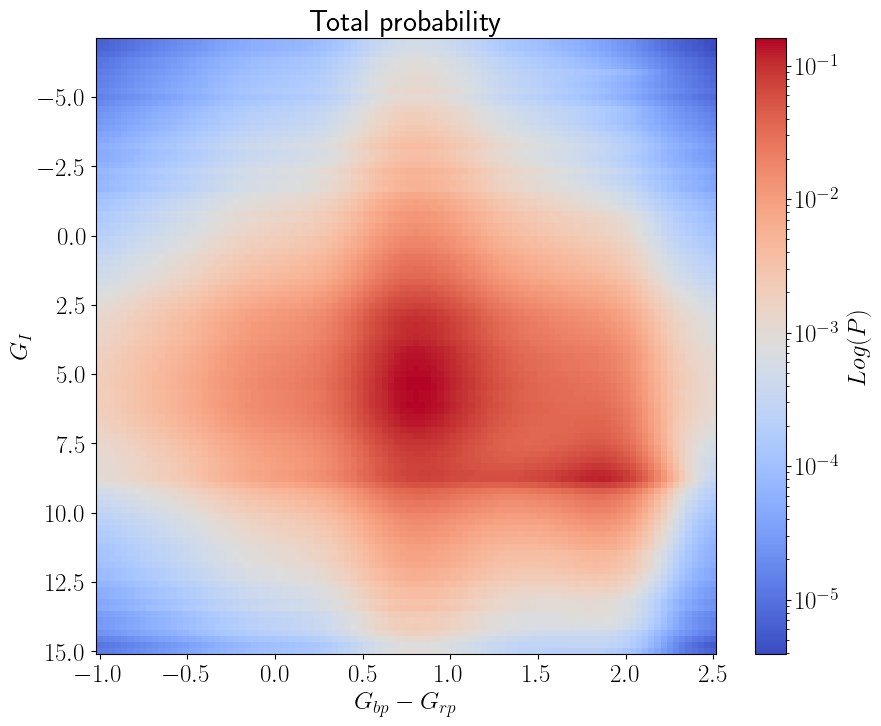

In [145]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, total_probability, cmap='coolwarm', shading='auto',  norm=colors.LogNorm(vmin=total_probability.min(), vmax=total_probability.max()))
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.invert_yaxis()
ax.set_title('Total probability')
fig.colorbar(c, label='$Log(P)$')
plt.show()

## Class structure

In [45]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class BayesianKDEClassifier:
    def __init__(self, X, Y, C, threshold=0.5, bandwidth=1.0):
        """
        Initialize a Bayesian classifier based on KDE (non-parametric approach).
        
        Parameters:
        - X (array-like): Input data for feature X.
        - Y (array-like): Input data for feature Y.
        - C (array-like): Boolean feature indicating if a point is in the True class.
        - threshold (float): Probability threshold for classification (default is 0.5).
        - bandwidth (float): Bandwidth for KDE (smoothing parameter).
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.bandwidth = bandwidth

        # Split data by class
        X_class = self.X[self.C]
        Y_class = self.Y[self.C]
        X_not_class = self.X[~self.C]
        Y_not_class = self.Y[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit KDEs for each feature in each class
        self.kde_x_class = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(X_class.reshape(-1, 1))
        self.kde_y_class = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(Y_class.reshape(-1, 1))
        self.kde_x_not_class = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(X_not_class.reshape(-1, 1))
        self.kde_y_not_class = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(Y_not_class.reshape(-1, 1))
        
    def classify(self, x, y):
        """
        Classify points based on the KDE-based Bayesian model.
        
        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        
        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        
        # Calculate log-likelihoods for all points at once
        log_p_x_given_class = self.kde_x_class.score_samples(x)
        log_p_y_given_class = self.kde_y_class.score_samples(y)
        log_p_x_given_not_class = self.kde_x_not_class.score_samples(x)
        log_p_y_given_not_class = self.kde_y_not_class.score_samples(y)
        
        # Convert log-likelihoods to likelihoods
        p_x_given_class = np.exp(log_p_x_given_class)
        p_y_given_class = np.exp(log_p_y_given_class)
        p_x_given_not_class = np.exp(log_p_x_given_not_class)
        p_y_given_not_class = np.exp(log_p_y_given_not_class)
        
        # Joint probabilities
        p_data_given_class = p_x_given_class * p_y_given_class
        p_data_given_not_class = p_x_given_not_class * p_y_given_not_class
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities P(class|data) and P(not class|data)
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
    
    def plot_kde(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Plot the 2D KDE distributions for both classes.
        
        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X, Y = np.meshgrid(x_i, y_i)
        X_flat, Y_flat = X.ravel(), Y.ravel()

        # Calculate KDE values for both classes
        log_prob_class_x = self.kde_x_class.score_samples(X_flat.reshape(-1, 1))
        log_prob_class_y = self.kde_y_class.score_samples(Y_flat.reshape(-1, 1))
        log_prob_not_class_x = self.kde_x_not_class.score_samples(X_flat.reshape(-1, 1))
        log_prob_not_class_y = self.kde_y_not_class.score_samples(Y_flat.reshape(-1, 1))

        # Calculate probabilities and reshape for plotting
        prob_class = np.exp(log_prob_class_x) * np.exp(log_prob_class_y)
        prob_not_class = np.exp(log_prob_not_class_x) * np.exp(log_prob_not_class_y)
        prob_class = prob_class.reshape(X.shape)
        prob_not_class = prob_not_class.reshape(X.shape)
        
        # Plot the KDEs
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        cbar_1 = ax[0].contourf(X, Y, prob_class, levels=20, cmap="Blues")
        ax[0].set_title("KDE for Class")
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")
        fig.colorbar(cbar_1, ax=ax[0], label='Probability')
        
        cbar_2 = ax[1].contourf(X, Y, prob_not_class, levels=20, cmap="Reds")
        ax[1].set_title("KDE for Not Class")
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        fig.colorbar(cbar_2, ax=ax[1], label='Probability')
        
        plt.show()


In [48]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])
bayes_classifier = BayesianKDEClassifier(X, Y, C, threshold=0.9, bandwidth=1e-2)

In [ ]:
bayes_classifier.plot_kde()

# Probabilities with errors

In [98]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class BayesianKDEClassifier:
    def __init__(self, X, Y, C, threshold=0.5, bandwidth=1.0):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.base_bandwidth = bandwidth

        # Split data by class
        X_class = self.X[self.C]
        Y_class = self.Y[self.C]
        X_not_class = self.X[~self.C]
        Y_not_class = self.Y[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit KDEs for each feature in each class with base bandwidth
        self.kde_x_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(X_class.reshape(-1, 1))
        self.kde_y_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(Y_class.reshape(-1, 1))
        self.kde_x_not_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(X_not_class.reshape(-1, 1))
        self.kde_y_not_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(Y_not_class.reshape(-1, 1))
        
    def classify(self, x, y, x_err=0, y_err=0):
        """
        Classify points based on the KDE-based Bayesian model with analytical error integration.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        - x_err (float or array-like): Standard deviation of errors in X.
        - y_err (float or array-like): Standard deviation of errors in Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        # Adjust the bandwidths based on measurement error
        effective_bandwidth_x_class = np.sqrt(self.base_bandwidth**2 + x_err**2)
        effective_bandwidth_y_class = np.sqrt(self.base_bandwidth**2 + y_err**2)
        effective_bandwidth_x_not_class = np.sqrt(self.base_bandwidth**2 + x_err**2)
        effective_bandwidth_y_not_class = np.sqrt(self.base_bandwidth**2 + y_err**2)
        
        # Create temporary KDEs with adjusted bandwidths for each case
        kde_x_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth_x_class)
        kde_x_class.fit(self.X[self.C].reshape(-1, 1))
        kde_y_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth_y_class)
        kde_y_class.fit(self.Y[self.C].reshape(-1, 1))
        
        kde_x_not_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth_x_not_class)
        kde_x_not_class.fit(self.X[~self.C].reshape(-1, 1))
        kde_y_not_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth_y_not_class)
        kde_y_not_class.fit(self.Y[~self.C].reshape(-1, 1))

        # Calculate log-likelihoods with adjusted KDEs
        log_p_x_given_class = kde_x_class.score_samples(np.array(x).reshape(-1, 1))
        log_p_y_given_class = kde_y_class.score_samples(np.array(y).reshape(-1, 1))
        log_p_x_given_not_class = kde_x_not_class.score_samples(np.array(x).reshape(-1, 1))
        log_p_y_given_not_class = kde_y_not_class.score_samples(np.array(y).reshape(-1, 1))
        
        # Convert log-likelihoods to likelihoods
        p_x_given_class = np.exp(log_p_x_given_class)
        p_y_given_class = np.exp(log_p_y_given_class)
        p_x_given_not_class = np.exp(log_p_x_given_not_class)
        p_y_given_not_class = np.exp(log_p_y_given_not_class)
        
        # Joint probabilities
        p_data_given_class = p_x_given_class * p_y_given_class
        p_data_given_not_class = p_x_given_not_class * p_y_given_not_class
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities P(class|data) and P(not class|data)
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
    
    def plot_kde(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Plot the 2D KDE distributions for both classes.
        
        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X, Y = np.meshgrid(x_i, y_i)
        X_flat, Y_flat = X.ravel(), Y.ravel()

        # Calculate KDE values for both classes
        log_prob_class_x = self.kde_x_class.score_samples(X_flat.reshape(-1, 1))
        log_prob_class_y = self.kde_y_class.score_samples(Y_flat.reshape(-1, 1))
        log_prob_not_class_x = self.kde_x_not_class.score_samples(X_flat.reshape(-1, 1))
        log_prob_not_class_y = self.kde_y_not_class.score_samples(Y_flat.reshape(-1, 1))

        # Calculate probabilities and reshape for plotting
        prob_class = np.exp(log_prob_class_x) * np.exp(log_prob_class_y)
        prob_not_class = np.exp(log_prob_not_class_x) * np.exp(log_prob_not_class_y)
        prob_class = prob_class.reshape(X.shape)
        prob_not_class = prob_not_class.reshape(X.shape)
        
        # Plot the KDEs
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        cbar_1 = ax[0].contourf(X, Y, prob_class, levels=20, cmap="Blues")
        ax[0].scatter(self.X[self.C], self.Y[self.C], color='yellow', alpha=0.1, s = 0.1, label='HVS')
        ax[0].scatter(self.X[~self.C], self.Y[~self.C], color='green', alpha=0.1, s = 0.1, label='Background')
        ax[0].set_title("KDE for Class")
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        fig.colorbar(cbar_1, ax=ax[0], label='Probability')
        
        cbar_2 = ax[1].contourf(X, Y, prob_not_class, levels=20, cmap="Reds")
        ax[1].scatter(self.X[self.C], self.Y[self.C], color='yellow', alpha=0.1, s = 0.1, label='HVS')
        ax[1].scatter(self.X[~self.C], self.Y[~self.C], color='green', alpha=0.1, s = 0.1, label='Background')
        ax[1].set_title("KDE for Not Class")
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        fig.colorbar(cbar_2, ax=ax[1], label='Probability')
        plt.legend()
        
        plt.show()
        
    



In [99]:
bayes_classifier_errors = BayesianKDEClassifier(X, Y, C, threshold=0.9, bandwidth=1e-2)

In [100]:
import time

In [101]:
start = time.time()
bayes_classifier_errors.classify(1.5, 4.7, x_err=0.1, y_err=0.1)    
end = time.time()
elapsed =  end - start
print("Time elapsed: ", end - start)
print('It would take:', elapsed*1.8e9/(3600*24), ' days to classify the entire Gaia catalog')

Time elapsed:  0.04911303520202637
It would take: 1023.1882333755493  days to classify the entire Gaia catalog


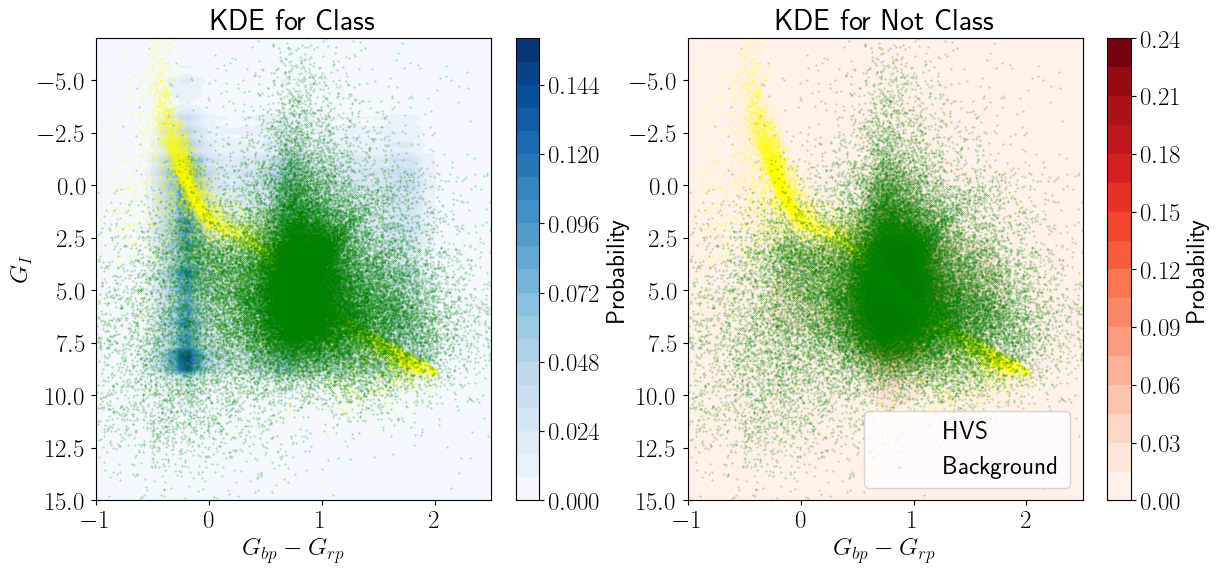

In [102]:
bayes_classifier_errors.plot_kde()

# Gaussian Mixture Model

In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np

class BayesianGMMClassifier:
    def __init__(self, X, Y, C, threshold=0.5, n_components=3):
        """
        Initialize a Bayesian classifier based on Gaussian Mixture Models (GMMs).

        Parameters:
        - X (array-like): Input data for feature X.
        - Y (array-like): Input data for feature Y.
        - C (array-like): Boolean feature indicating if a point is in the True class.
        - threshold (float): Probability threshold for classification (default is 0.5).
        - n_components (int): Number of components for the Gaussian Mixture Model.
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.n_components = n_components

        # Split data by class
        X_class = np.column_stack((self.X[self.C], self.Y[self.C]))
        X_not_class = np.column_stack((self.X[~self.C], self.Y[~self.C]))

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit GMM for each class
        self.gmm_class = GaussianMixture(n_components=self.n_components).fit(X_class)
        self.gmm_not_class = GaussianMixture(n_components=self.n_components).fit(X_not_class)
        
    def classify(self, x, y):
        """
        Classify points based on the GMM-based Bayesian model.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        xy = np.column_stack((x, y))

        # Calculate log-probabilities
        log_p_data_given_class = self.gmm_class.score_samples(xy)
        log_p_data_given_not_class = self.gmm_not_class.score_samples(xy)
        
        # Convert log-probabilities to probabilities
        p_data_given_class = np.exp(log_p_data_given_class)
        p_data_given_not_class = np.exp(log_p_data_given_not_class)
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
    
    def classify_errors(self, x, y, x_err=0, y_err=0):
        """
        Classify points based on the GMM-based Bayesian model with measurement errors.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        - x_err (float or array-like): Standard deviation of errors in X.
        - y_err (float or array-like): Standard deviation of errors in Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        # Prepare input data
        xy = np.column_stack((x, y))
        x_var = x_err ** 2
        y_var = y_err ** 2

        # Vectorized computation of adjusted covariances for "class" GMM
        adjusted_cov_class = self.gmm_class.covariances_ + np.array([[x_var, 0], [0, y_var]])
        adjusted_probs_class = np.sum(
            [
                weight * multivariate_normal(mean=mean, cov=adjusted_cov).pdf(xy)
                for mean, adjusted_cov, weight in zip(self.gmm_class.means_, adjusted_cov_class, self.gmm_class.weights_)
            ],
            axis=0
        )

        # Vectorized computation of adjusted covariances for "not class" GMM
        adjusted_cov_not_class = self.gmm_not_class.covariances_ + np.array([[x_var, 0], [0, y_var]])
        adjusted_probs_not_class = np.sum(
            [
                weight * multivariate_normal(mean=mean, cov=adjusted_cov).pdf(xy)
                for mean, adjusted_cov, weight in zip(self.gmm_not_class.means_, adjusted_cov_not_class, self.gmm_not_class.weights_)
            ],
            axis=0
        )

        # Total probability of data
        p_data = adjusted_probs_class * self.p_class + adjusted_probs_not_class * self.p_not_class

        # Posterior probabilities
        p_class_given_data = (adjusted_probs_class * self.p_class) / p_data
        p_not_class_given_data = (adjusted_probs_not_class * self.p_not_class) / p_data

        # Classification based on threshold
        classification = p_class_given_data >= self.threshold

        return classification, p_class_given_data, p_not_class_given_data, p_data
    

    
    def debug_gmm_fit(self, x_range=(0, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug GMM by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid for plotting GMM densities
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X, Y = np.meshgrid(x_i, y_i)
        xy_flat = np.column_stack([X.ravel(), Y.ravel()])

        # Calculate GMM density values for both classes
        prob_class = np.exp(self.gmm_class.score_samples(xy_flat)).reshape(X.shape)
        prob_not_class = np.exp(self.gmm_not_class.score_samples(xy_flat)).reshape(X.shape)

        # Plot the GMM and original data for each class
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot for the "class" data
        ax[0].scatter(self.X[self.C], self.Y[self.C], color="k", alpha= 0.8, s =1, label="Class Data")
        cbar_1 = ax[0].contourf(X, Y, prob_class/np.max(prob_class.ravel()), levels=20, cmap="Blues", alpha=0.6)
        ax[0].set_title("GMM Fit for Class")
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        fig.colorbar(cbar_1, ax=ax[0], label='$P(x)$')
        
        # Plot for the "not class" data
        ax[1].scatter(self.X[~self.C], self.Y[~self.C], color="red", alpha=0.5, s = 0.1, label="Not Class Data")
        cbar_2 = ax[1].contourf(X, Y, prob_not_class, levels=20, cmap="Reds", alpha=0.6)
        ax[1].set_title("GMM Fit for Not Class")
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        fig.colorbar(cbar_2, ax=ax[1], label='$P(X)$')

        plt.tight_layout()
        plt.show()


In [9]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])
gmm_classifier = BayesianGMMClassifier(X, Y, C, threshold=0.9, n_components=19)

## Time it would take for the version with errors

We expect this to be much slower due to the need to convolve the gaussian that represents the observation given the errors with the GMM

In [10]:
start = time.time()
gmm_classifier.classify_errors(1.5, 4.7, x_err=0.1, y_err=0.1)    
end = time.time()
elapsed =  end - start
print("Time elapsed: ", end - start)
print('It would take:', elapsed*1.8e9/(3600*24), ' days to classify the entire Gaia catalog')
print('With 200 cpu cores it would take:', elapsed*1.8e9/(3600*24*200), ' days to classify the entire Gaia catalog')

Time elapsed:  0.010088920593261719
It would take: 210.18584569295248  days to classify the entire Gaia catalog
With 200 cpu cores it would take: 1.0509292284647624  days to classify the entire Gaia catalog


## Time it would take without errors

In [11]:
start = time.time()
gmm_classifier.classify(1.5, 4.7)    
end = time.time()
elapsed =  end - start
print("Time elapsed: ", end - start)
print('It would take:', elapsed*1.8e9/(3600*24), ' days to classify the entire Gaia catalog')
print('With 200 cpu cores it would take:', elapsed*1.8e9/(3600*24*200), ' days to classify the entire Gaia catalog')

Time elapsed:  0.0023119449615478516
It would take: 48.16552003224691  days to classify the entire Gaia catalog
With 200 cpu cores it would take: 0.24082760016123453  days to classify the entire Gaia catalog


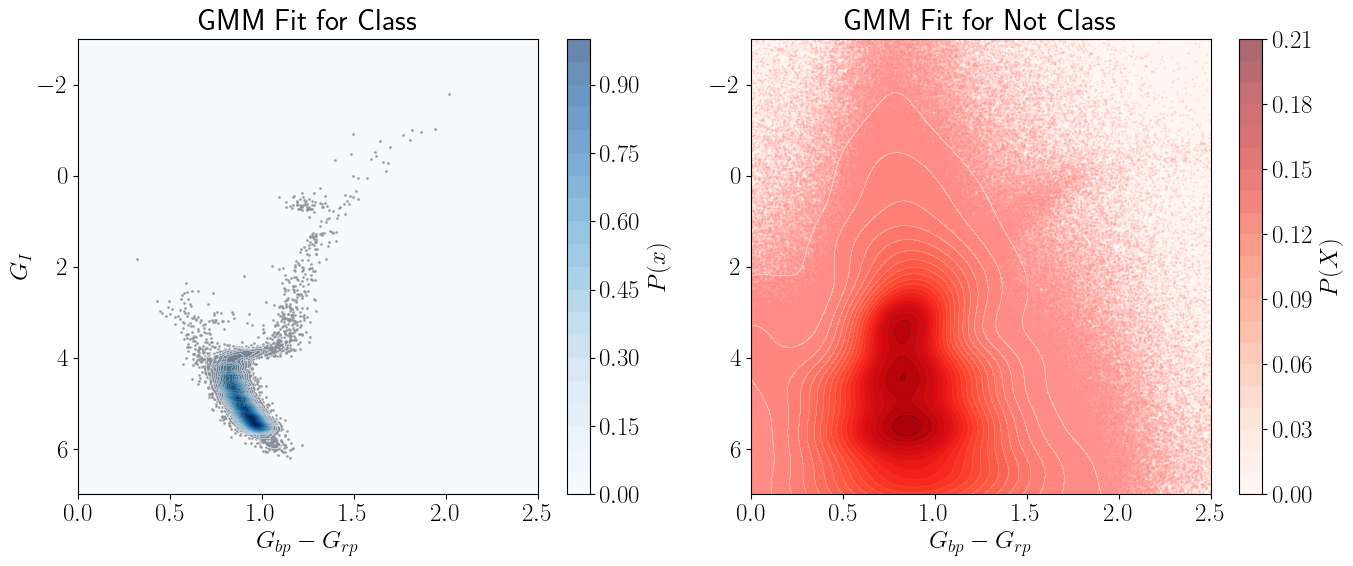

In [12]:
gmm_classifier.debug_gmm_fit(y_range=(7, -3), x_range=(0, 2.5))

In [13]:
# Generate the grid
x_i = np.linspace(-1, 2.5, 600)
y_i = np.linspace(15, -7, 600)
X, Y = np.meshgrid(x_i, y_i)

# Flatten X and Y to a 1D array of points
X_flat = X.ravel()
Y_flat = Y.ravel()

# Calculate probabilities for all points at once
classification, hvs_prob_flat, background_prob_flat, total_prob_flat = gmm_classifier.classify(X_flat, Y_flat)

# Reshape the results back to the grid shape
hvs_prob = hvs_prob_flat.reshape(X.shape)
background_prob = background_prob_flat.reshape(X.shape)
total_probability = total_prob_flat.reshape(X.shape)


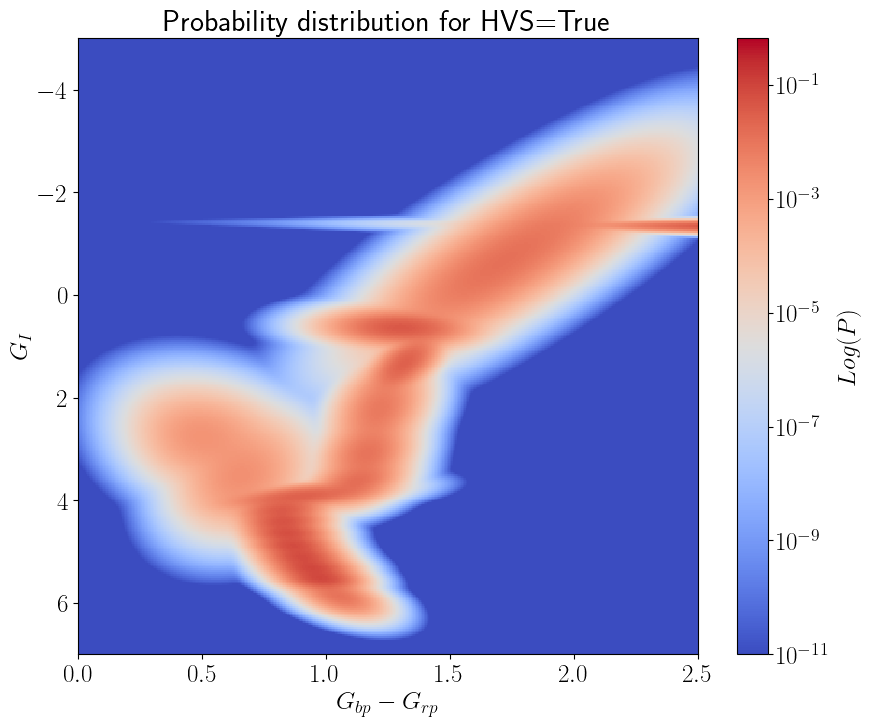

In [20]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm',  norm=colors.LogNorm(vmin=hvs_prob.min()+1e-11, vmax=hvs_prob.max()) ) #
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(0, 2.5)
ax.set_ylim(7, -5)
#ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$Log(P)$')
plt.show()

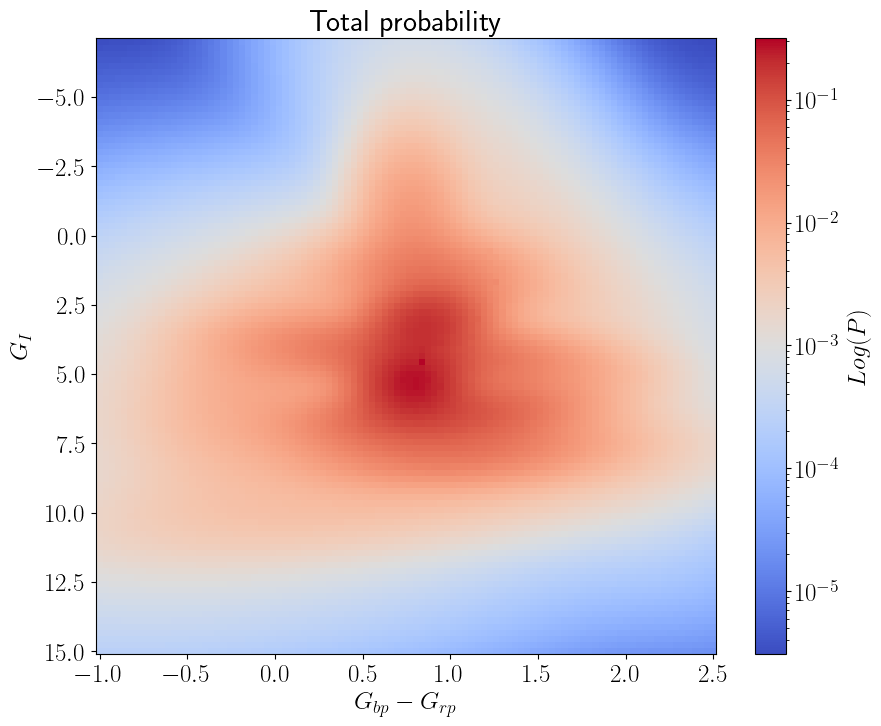

In [34]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, total_probability, cmap='coolwarm', shading='auto',  norm=colors.LogNorm(vmin=total_probability.min(), vmax=total_probability.max()))
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.invert_yaxis()
ax.set_title('Total probability')
fig.colorbar(c, label='$Log(P)$')
plt.show()

# Testing different models

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class MixtureOfLinearRegressions:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, Y):
        # Initialize parameters
        np.random.seed(self.random_state)
        n_samples = len(Y)
        K = self.n_components

        # Initialize mixing coefficients equally
        pi_k = np.ones(K) / K

        # Initialize regression coefficients
        beta_k = np.zeros((K, 2))  # Each beta_k is (intercept, slope)

        # Initialize variances
        sigma2_k = np.ones(K)

        # Responsibilities
        gamma_ik = np.zeros((n_samples, K))

        # Initialize beta_k using KMeans clustering on X
        from sklearn.cluster import KMeans
        X_reshaped = X.reshape(-1, 1)
        kmeans = KMeans(n_clusters=K, random_state=self.random_state).fit(X_reshaped)
        labels = kmeans.labels_
        for k in range(K):
            idx = labels == k
            if np.sum(idx) > 1:
                # Fit linear regression
                Xk = X[idx]
                Yk = Y[idx]
                X_design = np.vstack([np.ones(len(Xk)), Xk]).T
                beta = np.linalg.lstsq(X_design, Yk, rcond=None)[0]
                beta_k[k] = beta
                residuals = Yk - (beta[0] + beta[1]*Xk)
                sigma2_k[k] = np.var(residuals)
            else:
                beta_k[k] = np.random.randn(2)
                sigma2_k[k] = np.var(Y)

        log_likelihoods = []
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            for k in range(K):
                mu_k = beta_k[k, 0] + beta_k[k, 1]*X
                sigma_k = np.sqrt(sigma2_k[k])
                gamma_ik[:, k] = pi_k[k] * (1 / (np.sqrt(2 * np.pi) * sigma_k)) * np.exp(-0.5 * ((Y - mu_k) / sigma_k) **2)

            # Normalize responsibilities
            gamma_ik_sum = np.sum(gamma_ik, axis=1, keepdims=True)
            gamma_ik /= gamma_ik_sum

            # Compute log-likelihood
            ll = np.sum(np.log(np.sum(gamma_ik * pi_k, axis=1)))
            log_likelihoods.append(ll)

            # Check convergence
            if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tol:
                break

            # M-step: Update parameters
            Nk = np.sum(gamma_ik, axis=0)
            pi_k = Nk / n_samples
            for k in range(K):
                gamma_k = gamma_ik[:, k]
                W = np.diag(gamma_k)
                X_design = np.vstack([np.ones(n_samples), X]).T
                # Weighted least squares
                beta = np.linalg.lstsq(X_design.T @ W @ X_design, X_design.T @ W @ Y, rcond=None)[0]
                beta_k[k] = beta
                mu_k = beta[0] + beta[1]*X
                sigma2_k[k] = np.sum(gamma_k * (Y - mu_k) ** 2) / Nk[k]

        self.pi_k = pi_k
        self.beta_k = beta_k
        self.sigma2_k = sigma2_k
        self.log_likelihoods = log_likelihoods

    def predict_proba(self, X, Y):
        n_samples = len(Y)
        K = self.n_components
        gamma_ik = np.zeros((n_samples, K))
        for k in range(K):
            mu_k = self.beta_k[k, 0] + self.beta_k[k, 1]*X
            sigma_k = np.sqrt(self.sigma2_k[k])
            gamma_ik[:, k] = self.pi_k[k] * (1 / (np.sqrt(2 * np.pi) * sigma_k)) * np.exp(-0.5 * ((Y - mu_k) / sigma_k) **2)
        # Total probability density
        p_data = np.sum(gamma_ik, axis=1)
        return p_data

    def responsibilities(self, X, Y):
        n_samples = len(Y)
        K = self.n_components
        gamma_ik = np.zeros((n_samples, K))
        for k in range(K):
            mu_k = self.beta_k[k, 0] + self.beta_k[k, 1]*X
            sigma_k = np.sqrt(self.sigma2_k[k])
            gamma_ik[:, k] = self.pi_k[k] * (1 / (np.sqrt(2 * np.pi) * sigma_k)) * np.exp(-0.5 * ((Y - mu_k) / sigma_k) **2)
        # Normalize responsibilities
        gamma_ik_sum = np.sum(gamma_ik, axis=1, keepdims=True)
        gamma_ik /= gamma_ik_sum
        return gamma_ik

    def predict(self, X):
        K = self.n_components
        mu = np.zeros(len(X))
        for k in range(K):
            mu_k = self.beta_k[k, 0] + self.beta_k[k, 1]*X
            mu += self.pi_k[k] * mu_k
        return mu

class BayesianMoLRClassifier:
    def __init__(self, X, Y, C, threshold=0.5, n_components=3):
        """
        Initialize a Bayesian classifier based on Mixture of Linear Regressions.

        Parameters:
        - X (array-like): Input data for feature X.
        - Y (array-like): Input data for feature Y.
        - C (array-like): Boolean feature indicating if a point is in the True class.
        - threshold (float): Probability threshold for classification (default is 0.5).
        - n_components (int): Number of components for the Mixture of Linear Regressions.
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.n_components = n_components

        # Split data by class
        X_class = self.X[self.C]
        Y_class = self.Y[self.C]
        X_not_class = self.X[~self.C]
        Y_not_class = self.Y[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit Mixture of Linear Regressions for each class
        self.molr_class = MixtureOfLinearRegressions(n_components=self.n_components, random_state=0)
        self.molr_class.fit(X_class, Y_class)

        self.molr_not_class = MixtureOfLinearRegressions(n_components=self.n_components, random_state=0)
        self.molr_not_class.fit(X_not_class, Y_not_class)
        
    def classify(self, x, y):
        """
        Classify points based on the Mixture of Linear Regressions Bayesian model.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        x = np.array(x)
        y = np.array(y)

        # Compute the probability density under each model
        p_data_given_class = self.molr_class.predict_proba(x, y)
        p_data_given_not_class = self.molr_not_class.predict_proba(x, y)

        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class

        # Posterior probabilities
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data

        # Classification based on threshold
        classification = p_class_given_data >= self.threshold

        return classification, p_class_given_data, p_not_class_given_data, p_data

    def debug_fit(self, x_range=(0, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug Mixture of Linear Regressions by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot.
        - y_range (tuple): Range of y values for the plot.
        - resolution (int): Number of points along each axis.
        """
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X_grid, Y_grid = np.meshgrid(x_i, y_i)
        xy_flat = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
        x_flat = xy_flat[:, 0]
        y_flat = xy_flat[:, 1]

        # Compute probabilities for each point in the grid
        prob_class = self.molr_class.predict_proba(x_flat, y_flat).reshape(X_grid.shape)
        prob_not_class = self.molr_not_class.predict_proba(x_flat, y_flat).reshape(X_grid.shape)

        # Plot the fits and original data
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot for the "class" data
        ax[0].scatter(self.X[self.C], self.Y[self.C], color="blue", alpha=0.5, s=1, label="Class Data")
        cbar_1 = ax[0].contourf(X_grid, Y_grid, prob_class / np.max(prob_class), levels=20, cmap="Blues", alpha=1)
        ax[0].set_title("Mixture of Linear Regressions Fit for Class")
        ax[0].set_xlabel("$X$")
        ax[0].set_ylabel("$Y$")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        fig.colorbar(cbar_1, ax=ax[0], label='$P(x)$')

        # Plot the regression lines
        for k in range(self.n_components):
            beta = self.molr_class.beta_k[k]
            y_line = beta[0] + beta[1]*x_i
            ax[0].plot(x_i, y_line, color='black', linestyle='--', linewidth=1)

        # Plot for the "not class" data
        ax[1].scatter(self.X[~self.C], self.Y[~self.C], color="red", alpha=0.5, s=0.1, label="Not Class Data")
        cbar_2 = ax[1].contourf(X_grid, Y_grid, prob_not_class / np.max(prob_not_class), levels=20, cmap="Reds", alpha=0.6)
        ax[1].set_title("Mixture of Linear Regressions Fit for Not Class")
        ax[1].set_xlabel("$X$")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        fig.colorbar(cbar_2, ax=ax[1], label='$P(X)$')

        # Plot the regression lines
        for k in range(self.n_components):
            beta = self.molr_not_class.beta_k[k]
            y_line = beta[0] + beta[1]*x_i
            ax[1].plot(x_i, y_line, color='black', linestyle='--', linewidth=1)

        plt.tight_layout()
        plt.show()


In [ ]:
# Initialize the classifier
classifier = BayesianMoLRClassifier(X, Y, C, threshold=0.5, n_components=3)

In [ ]:
# Classify new data points
classification, p_class_given_data, p_not_class_given_data, p_data = classifier.classify(1.5, 4.7)

# Visualize the fits
classifier.debug_fit()


## With RobustScaling

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class GMMClassifier_2:
    def __init__(self, X, Y, C, threshold=0.5, n_components=3):
        """
        Initialize a Bayesian classifier based on Gaussian Mixture Models (GMMs),
        with data scaling to improve GMM fitting.

        Parameters:
        - X (array-like): Input data for feature X.
        - Y (array-like): Input data for feature Y.
        - C (array-like): Boolean feature indicating if a point is in the True class.
        - threshold (float): Probability threshold for classification (default is 0.5).
        - n_components (int): Number of components for the Gaussian Mixture Model.
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.n_components = n_components

        # Stack X and Y for scaling
        XY = np.column_stack((self.X, self.Y))

        # Initialize and fit the RobustScaler
        self.scaler = RobustScaler()
        self.scaler.fit(XY)

        # Scale the data
        XY_scaled = self.scaler.transform(XY)

        # Split scaled data by class
        X_class_scaled = XY_scaled[self.C]
        X_not_class_scaled = XY_scaled[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit GMM for each class on scaled data
        self.gmm_class = GaussianMixture(n_components=self.n_components).fit(X_class_scaled)
        self.gmm_not_class = GaussianMixture(n_components=self.n_components).fit(X_not_class_scaled)

    def classify(self, x, y):
        """
        Classify points based on the GMM-based Bayesian model.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        xy = np.column_stack((x, y))

        # Scale the input data
        xy_scaled = self.scaler.transform(xy)

        # Calculate log-probabilities using scaled data
        log_p_data_given_class = self.gmm_class.score_samples(xy_scaled)
        log_p_data_given_not_class = self.gmm_not_class.score_samples(xy_scaled)

        # Convert log-probabilities to probabilities
        p_data_given_class = np.exp(log_p_data_given_class)
        p_data_given_not_class = np.exp(log_p_data_given_not_class)

        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class

        # Posterior probabilities
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data

        # Classification based on threshold
        classification = p_class_given_data >= self.threshold

        return classification, p_class_given_data, p_not_class_given_data, p_data

    def debug_gmm_fit(self, x_range=(0, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug GMM by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (0, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid for plotting in original data space
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X_grid, Y_grid = np.meshgrid(x_i, y_i)
        xy_flat = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

        # Scale the grid data
        xy_flat_scaled = self.scaler.transform(xy_flat)

        # Calculate GMM density values for both classes using scaled data
        prob_class = np.exp(self.gmm_class.score_samples(xy_flat_scaled)).reshape(X_grid.shape)
        prob_not_class = np.exp(self.gmm_not_class.score_samples(xy_flat_scaled)).reshape(X_grid.shape)

        # Plot the GMM and original data for each class
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot for the "class" data
        ax[0].scatter(self.X[self.C], self.Y[self.C], color="k", alpha=0.8, s=1, label="Class Data")
        cbar_1 = ax[0].contourf(X_grid, Y_grid, prob_class / np.max(prob_class), levels=20, cmap="Blues", alpha=0.6)
        ax[0].set_title("GMM Fit for Class")
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        fig.colorbar(cbar_1, ax=ax[0], label='$P(x)$')

        # Plot for the "not class" data
        ax[1].scatter(self.X[~self.C], self.Y[~self.C], color="red", alpha=0.5, s=0.1, label="Not Class Data")
        cbar_2 = ax[1].contourf(X_grid, Y_grid, prob_not_class / np.max(prob_not_class), levels=20, cmap="Reds", alpha=0.6)
        ax[1].set_title("GMM Fit for Not Class")
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        fig.colorbar(cbar_2, ax=ax[1], label='$P(x)$')

        plt.tight_layout()
        plt.show()

    def debug_gmm_fit_scaled(self, x_range=(-3, 3), y_range=(-3, 3), resolution=100):
        """
        Debug GMM by plotting it in the scaled data space to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot in scaled space (default is (-3, 3)).
        - y_range (tuple): Range of y values for the plot in scaled space (default is (-3, 3)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid in scaled space
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X_grid, Y_grid = np.meshgrid(x_i, y_i)
        xy_flat_scaled = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

        # Calculate GMM density values for both classes using scaled data
        prob_class = np.exp(self.gmm_class.score_samples(xy_flat_scaled)).reshape(X_grid.shape)
        prob_not_class = np.exp(self.gmm_not_class.score_samples(xy_flat_scaled)).reshape(X_grid.shape)

        # Get scaled data for plotting
        X_class_scaled = self.scaler.transform(np.column_stack((self.X[self.C], self.Y[self.C])))
        X_not_class_scaled = self.scaler.transform(np.column_stack((self.X[~self.C], self.Y[~self.C])))

        # Plot the GMM densities in scaled space
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot for the "class" data
        ax[0].scatter(X_class_scaled[:, 0], X_class_scaled[:, 1], color="k", alpha=0.8, s=1, label="Class Data")
        cbar_1 = ax[0].contourf(X_grid, Y_grid, prob_class / np.max(prob_class), levels=20, cmap="Blues", alpha=0.6)
        ax[0].set_title("GMM Fit for Class (Scaled Space)")
        ax[0].set_xlabel("Scaled Feature X")
        ax[0].set_ylabel("Scaled Feature Y")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        fig.colorbar(cbar_1, ax=ax[0], label='$P(x)$')

        # Plot for the "not class" data
        ax[1].scatter(X_not_class_scaled[:, 0], X_not_class_scaled[:, 1], color="red", alpha=0.5, s=0.1, label="Not Class Data")
        cbar_2 = ax[1].contourf(X_grid, Y_grid, prob_not_class / np.max(prob_not_class), levels=20, cmap="Reds", alpha=0.6)
        ax[1].set_title("GMM Fit for Not Class (Scaled Space)")
        ax[1].set_xlabel("Scaled Feature X")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        fig.colorbar(cbar_2, ax=ax[1], label='$P(x)$')

        plt.tight_layout()
        plt.show()



In [31]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])
gmm_classifier_2 = GMMClassifier_2(X, Y, C, threshold=0.9, n_components=19)

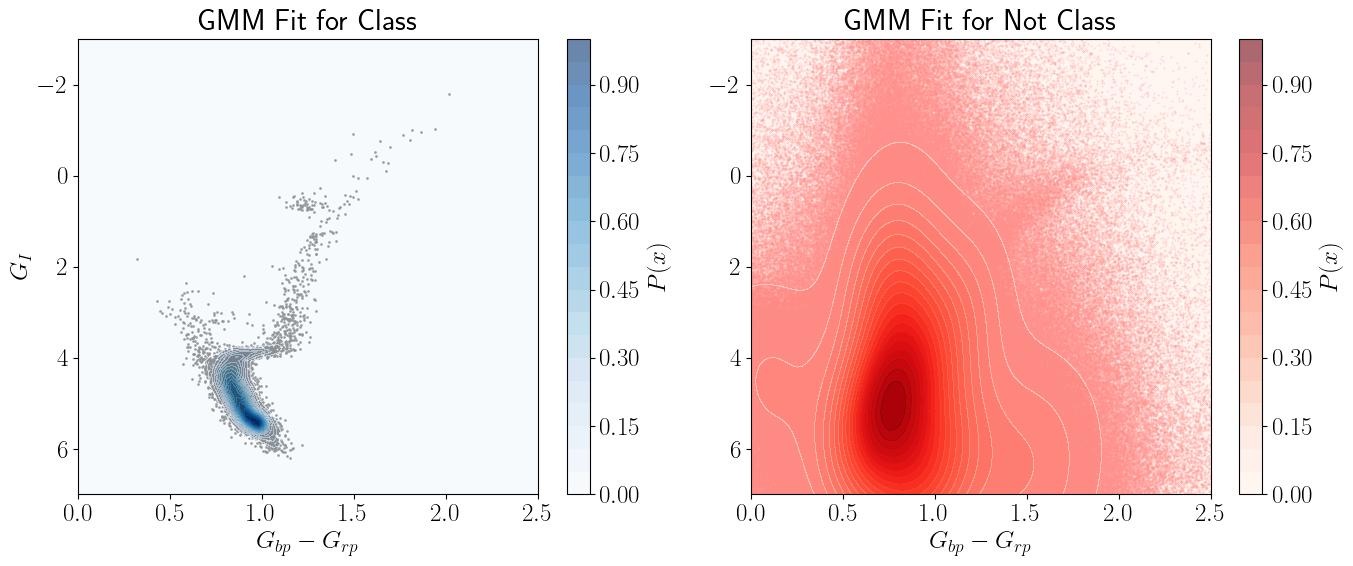

In [23]:
gmm_classifier_2.debug_gmm_fit(y_range=(7, -3), x_range=(0, 2.5))

In [24]:
# Generate the grid
x_i = np.linspace(-1, 2.5, 600)
y_i = np.linspace(15, -7, 600)
X, Y = np.meshgrid(x_i, y_i)

# Flatten X and Y to a 1D array of points
X_flat = X.ravel()
Y_flat = Y.ravel()

# Calculate probabilities for all points at once
classification, hvs_prob_flat, background_prob_flat, total_prob_flat = gmm_classifier_2.classify(X_flat, Y_flat)

# Reshape the results back to the grid shape
hvs_prob = hvs_prob_flat.reshape(X.shape)
background_prob = background_prob_flat.reshape(X.shape)
total_probability = total_prob_flat.reshape(X.shape)


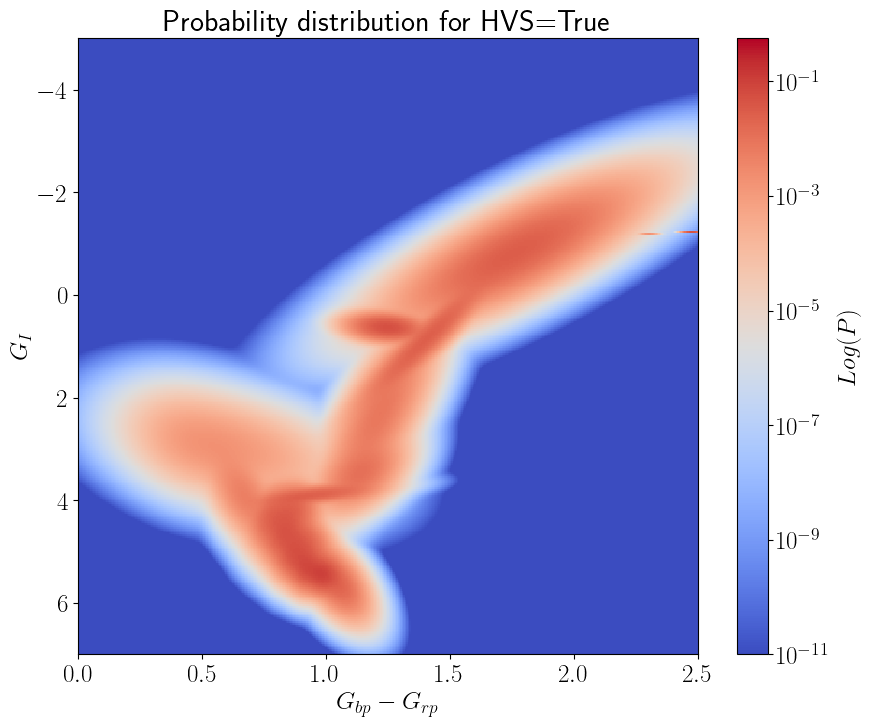

In [25]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm',  norm=colors.LogNorm(vmin=hvs_prob.min()+1e-11, vmax=hvs_prob.max()) ) #
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(0, 2.5)
ax.set_ylim(7, -5)
#ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$Log(P)$')
plt.show()

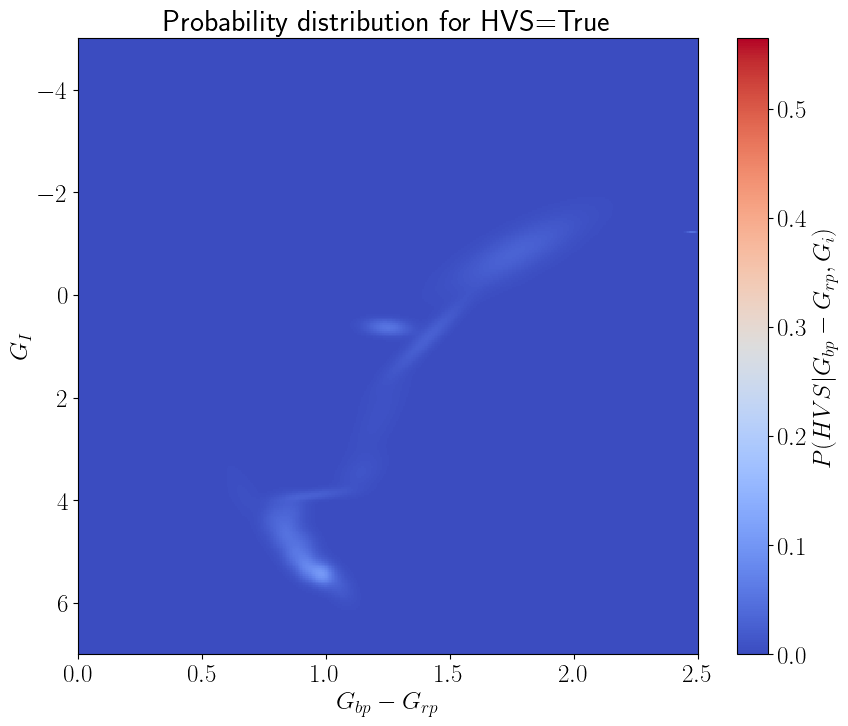

In [29]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm', shading= 'auto')#,  norm=colors.LogNorm(vmin=hvs_prob.min()+1e-11, vmax=hvs_prob.max()) ) #
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(0, 2.5)
ax.set_ylim(7, -5)
#ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$P(HVS|G_{bp} - G_{rp}, G_i)$')
plt.show()

# KDE with RobustScaling

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class BayesianKDEClassifier:
    def __init__(self, X, Y, C, threshold=0.5, bandwidth=1.0):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.base_bandwidth = bandwidth

        # Split data by class
        X_class = self.X[self.C]
        Y_class = self.Y[self.C]
        X_not_class = self.X[~self.C]
        Y_not_class = self.Y[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit 2D KDEs for each class with base bandwidth
        XY_class = np.vstack([X_class, Y_class]).T
        XY_not_class = np.vstack([X_not_class, Y_not_class]).T

        self.kde_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_class)
        self.kde_not_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_not_class)
        
    def classify(self, x, y, x_err=0, y_err=0):
        """
        Classify points based on the KDE-based Bayesian model with analytical error integration.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        - x_err (float or array-like): Standard deviation of errors in X.
        - y_err (float or array-like): Standard deviation of errors in Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        # Adjust the bandwidth based on measurement error (assuming isotropic errors)
        effective_bandwidth = np.sqrt(self.base_bandwidth**2 + x_err**2 + y_err**2)
        
        # Create temporary KDEs with adjusted bandwidths for each case
        kde_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        kde_class.fit(np.vstack([self.X[self.C], self.Y[self.C]]).T)
        
        kde_not_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        kde_not_class.fit(np.vstack([self.X[~self.C], self.Y[~self.C]]).T)
        
        # Prepare input data
        data = np.vstack([x, y]).T
        
        # Calculate log-likelihoods with adjusted KDEs
        log_p_data_given_class = kde_class.score_samples(data)
        log_p_data_given_not_class = kde_not_class.score_samples(data)
        
        # Convert log-likelihoods to likelihoods
        p_data_given_class = np.exp(log_p_data_given_class)
        p_data_given_not_class = np.exp(log_p_data_given_not_class)
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities P(class|data) and P(not class|data)
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
        
    def debug_kde_fit(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug KDE by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """
        # Create a meshgrid for plotting KDE densities
        x_i = np.linspace(x_range[0], x_range[1], resolution)
        y_i = np.linspace(y_range[0], y_range[1], resolution)
        X_grid, Y_grid = np.meshgrid(x_i, y_i)
        grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

        # Calculate KDE density values for both classes
        log_prob_class = self.kde_class.score_samples(grid_points)
        prob_class = np.exp(log_prob_class).reshape(X_grid.shape)
        log_prob_not_class = self.kde_not_class.score_samples(grid_points)
        prob_not_class = np.exp(log_prob_not_class).reshape(X_grid.shape)

        # Plot the KDE and original data for each class
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        # Subsample data for faster plotting
        n_points = 1000  # Number of points to plot
        idx_class_all = np.where(self.C)[0]
        idx_not_class_all = np.where(~self.C)[0]
        idx_class = np.random.choice(idx_class_all, size=min(n_points, len(idx_class_all)), replace=False)
        idx_not_class = np.random.choice(idx_not_class_all, size=min(n_points, len(idx_not_class_all)), replace=False)
        
        # Plot for the "class" data
        ax[0].scatter(self.X[idx_class], self.Y[idx_class], color="blue", alpha=0.5, s=10, label="Class Data")
        cbar_1 = ax[0].contour(X_grid, Y_grid, prob_class / np.max(prob_class.ravel()), levels=10, cmap="Blues")
        ax[0].set_title("KDE Fit for Class")
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        ax[0].legend()
        
        # Plot for the "not class" data
        ax[1].scatter(self.X[idx_not_class], self.Y[idx_not_class], color="red", alpha=0.5, s=10, label="Not Class Data")
        cbar_2 = ax[1].contour(X_grid, Y_grid, prob_not_class / np.max(prob_not_class.ravel()), levels=10, cmap="Reds")
        ax[1].set_title("KDE Fit for Not Class")
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        ax[1].legend()
        
        # Add colorbars
        fig.colorbar(cbar_1, ax=ax[0], label='$P(x)$')
        fig.colorbar(cbar_2, ax=ax[1], label='$P(x)$')
        
        plt.tight_layout()
        plt.show()


In [11]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])

# Assuming you have your data in variables X_data, Y_data, and Class_labels
classifier = BayesianKDEClassifier(X, Y, C, bandwidth=0.1)

# To classify new data points
#classification, p_class, p_not_class, p_data = classifier.classify(new_X, new_Y, x_err, y_err)




In [ ]:
# To plot the KDEs
classifier.plot_kde()